In [245]:
from itertools import product, tee
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats import spearmanr
from sklearn.metrics import matthews_corrcoef
import operator
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from nmtf_embedding import load
from sklearn.metrics import silhouette_score

# GLOBAL SETTINGS

## Annotation files

In [117]:
CANCER_GENES_FILE = './data/annotations/cosmic_drivers.txt'  # Each row is an entrez gene id.
ENTREZ_2_SYMBOL_FILE = './data/annotations/mart_export_entrez_symbol.txt'  # Maps entrez to gene symbol.
CANCER_PATHWAYS_FILE = './data/annotations/cancer_pathways_reactome.txt'  # Cancer pathway in Reactome DB
REACTOME_PATHWAY_NAMES_FILE = './data/annotations/ReactomePathways_human.txt'  # Maps pathway IDs to names
DTI_FILE = './data/Drug_Target_Interactions.csv'  # Relates drugs and genes (drug targets)
DRUG_STATUS_FILE = './data/Drug_Groups.csv'  # Drug status (e.g. experimental, approved, ...)
IMMUNE_PATHWAYS_FILE = './data/immune_system_pathways.txt'  # Pathways part of the immune system in Reactome DB

## Parameters

In [225]:
TISSUES = ['lung', 'colon', 'ovary','prostate']
GRAPHLETS = range(9)
SCORE_METHODS = ['centrality', 'moving_distance', 'hybrid']
THRESHOLD_PATHWAYS = 100
THRESHOLD_GENES = 100

# Helper functions

## Reading 

In [263]:
def __read_pathway_2_driver_ratio(tissue):
    fp = f'data/annotations/pathway_2_ratio_drivers_{tissue}.csv'
    with open(fp) as istr:
        pathway_2_driver_ratio = {row[0]: float(row[1]) for row in csv.reader(istr, delimiter=',')}
    return pathway_2_driver_ratio


def __read_cancer_genes():
    return set([line.strip() for line in open(CANCER_GENES_FILE)])


def __read_cancer_genes_tissue_specific(tissue):
    file_path = f'./data/annotations/cosmic_drivers_{tissue}.txt'
    return set([line.strip() for line in open(file_path)])


def __read_cancer_pathways():
    return set([line.strip() for line in open(CANCER_PATHWAYS_FILE)])


def __read_immune_pathways():
    return set([line.strip() for line in open(IMMUNE_PATHWAYS_FILE)])


def __read_entrez_2_symbol():

    entrez_2_symbol = {}
    with open(ENTREZ_2_SYMBOL_FILE) as ifs:
        next(ifs)
        for line in ifs:
            line = line.strip().split('\t')
            if len(line) == 2:  # A mapping exists
                symbol = line[1]
                entrez = line[0]

                if entrez in entrez_2_symbol:
                    entrez_2_symbol[entrez].add(symbol)
                else:
                    entrez_2_symbol[entrez] = {symbol}

    return entrez_2_symbol
    
    
def __read_cancer_genes_tissue_specific(tissue):
    file_path = f'./data/annotations/cosmic_drivers_{tissue}.txt'
    return set([line.strip() for line in open(file_path)])


def __read_path_2_name():
    
    path_2_name = {}
    with open (REACTOME_PATHWAY_NAMES_FILE) as istr:
        for line in istr:
            line = line.strip().split('\t')
            path_id = line[0]
            path_name = line[1]
            path_2_name[path_id] = path_name
    return path_2_name


def __read_gene_2_drugs(drugstatus_set=None):
    
    df_dti = pd.read_csv(DTI_FILE, sep=',')
    
    if drugstatus_set:
        df_ds = pd.read_csv(DRUG_STATUS_FILE)
        drug_2_status = dict()
        for row in df_ds.iloc():
            name = row['DrugBank Name']
            status = row['Group']
            drug_2_status[row['DrugBank ID']] = status
    gene_2_drugs = dict()
    for gene, drug in zip(df_dti['Gene Target'], df_dti['DrugBank ID']):
        if drugstatus_set is None or drug_2_status[drug] in drugstatus_set:
            if gene in gene_2_drugs:
                gene_2_drugs[gene].append(drug)
            else:
                gene_2_drugs[gene]=[drug]
    return gene_2_drugs


def __read_drug_2_name():
    df_ds = pd.read_csv(DRUG_STATUS_FILE)
    drug_2_name = dict()
    for row in df_ds.iloc():
        name = row['DrugBank Name']
        status = row['Group']
        drug_2_name[row['DrugBank ID']] = f'{name} ({status})'
    return drug_2_name


def __read_gene_2_prognostic(tissue):
    gene_2_prognostic_file = f'./data/annotations/prognostic_genes/{tissue}_prognostic_genes.tsv'
    df = pd.read_csv(gene_2_prognostic_file, sep='\t', dtype={'entrez':str})
    gene_2_prognostic = {}
    for index, row in df.iterrows():
        gene_2_prognostic[row['entrez']] = (row['type'],  row['pval'])
    return gene_2_prognostic


def __read_top_pathways(score_method, tissue, graphlet):
    fp = f'./pathway_scores/pathway_scores_PNMTF_{score_method}_{tissue}_{graphlet}.csv'
    df = pd.read_csv(fp)
    df = df.dropna()
    df = df[:THRESHOLD_PATHWAYS]
    return df


def __read_genes_for_top_pathways(score_method, tissue, graphlet):
    top_pathways = __read_top_pathways(score_method, tissue, graphlet)
    top_pathways = set(top_pathways['entity'].tolist())
    fp = f'./gene_scores/gene_scores_PNMTF_{score_method}_{tissue}_{graphlet}.csv'
    df = pd.read_csv(fp, dtype={'entity' : str})
    df = df.dropna()
    df = df[df['pathway'].isin(top_pathways)]
    df = df.drop_duplicates(['entity'],keep='first')
    df['rank'] = df.score.rank(ascending=False)
    df = df.sort_values(by=['score'], ascending=False)
    return df




## Plotting

In [265]:
def __plot_barchart(df, x, y, hue, title, ylim=None, ystep=None, file_path=None):
    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    fig1, ax1 = plt.subplots(figsize=(10,3.5))

    ax = sns.barplot(data=df, x=x, y=y, hue=hue, dodge=True)
    if hue is not None:
        plt.legend(loc=9, bbox_to_anchor=(0.5, -0.27), ncol=3, fontsize=20)

    plt.subplots_adjust(bottom=0.25,left=0.1,right=0.95)
    if title is not None and len(title)>0:
        plt.suptitle(title)
    plt.xlabel('')
    
    if ylim is not None and ystep is not None:
        plt.yticks(np.arange(ylim[0], ylim[1], ystep))
    
    if file_path is not None:
        plt.savefig(file_path,  bbox_inches='tight', pad_inches=0)
        

def __plot_lineplot(df, x, y, hue, vline=None, file_path=None):   
    sns.set_style("whitegrid")
    fig1, ax1 = plt.subplots(figsize=(11,6))
    ax = sns.lineplot(data=df, x=x, y=y ,hue=hue, ci=95, err_style='band')
    if vline is not None:
        ax.axvline(x=vline, color='purple')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.27), ncol=df[hue].nunique(), fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=handles[1:], labels=labels[1:])
    plt.subplots_adjust(bottom=0.25,left=0.1,right=0.95)
        
    if file_path is not None:
        plt.savefig(file_path,  bbox_inches='tight', pad_inches=0)
        
        
def __plot_clustergrid(row_linkage, col_linkage, no_clusters, cbar_label=None, title=None, file_path=None):
    
    
    cluster_assignment = hierarchy.fcluster(col_linkage, 
                                            no_clusters,
                                            criterion='maxclust')
    
    colors = ["xkcd:blue", "xkcd:red", "xkcd:green", "xkcd:black", "xkcd:pink", 
              "xkcd:yellow", "xkcd:olive", "xkcd:lavender", "xkcd:mauve", "xkcd:sea green", 
              "xkcd:teal", "xkcd:navy blue", "xkcd:lime green"]*5
    
    col_colors = []
    for cluster in cluster_assignment:
        col_colors.append(colors[cluster-1])

    cmap_clustermap = plt.get_cmap('jet')
    cm = sns.clustermap(squareform(dist_matrix), 
                        row_linkage=row_linkage, 
                        col_linkage=col_linkage, 
                        col_colors=col_colors,
                        method="average", 
                        figsize=(13, 12), 
                        cmap=cmap_clustermap,
                        dendrogram_ratio = (0.2, 0.1), # default 0.2
                        cbar_pos =(0.09, .28, .03, 0.30),
                        vmin=0, 
                        vmax=1.0,
                        cbar_kws =dict(orientation='vertical'))
    
    # Hide leftdendrogram
    cm.ax_row_dendrogram.remove()

    fontsize=20
    if cbar_label is not None:
        plt.ylabel(cbar_label, fontsize=fontsize) #colorbar a
    plt.gca().tick_params(labelsize=20)
    cm.ax_heatmap.set_ylabel("Pathways", fontsize=fontsize)
    cm.ax_heatmap.set_xlabel("Pathways", fontsize=fontsize)
    cm.ax_heatmap.set_xticks([])
    cm.ax_heatmap.set_yticks([])

    if title is not None:
        plt.suptitle(title)
        
    cophenetic_correlation, _ = hierarchy.cophenet(row_linkage, Y=dist_matrix)
    ss =  silhouette_score(squareform(dist_matrix), 
                           cluster_assignment, 
                           metric='precomputed')
    
    print("coph corr:", cophenetic_correlation)
    print("silhouette score:", ss)
    if file_path is not None:
        plt.savefig(file_path,  bbox_inches='tight', pad_inches=0)        

## Mapping

In [133]:
def __map_gene_to_clinical_type(gene,  gene_2_prognostic):
    if gene in gene_2_prognostic:
        return gene_2_prognostic[gene][0]
    else:
        return None

def __map_entrez_to_symbol(entrez, entrez_2_symbol):
    if entrez in entrez_2_symbol:
        return ','.join(entrez_2_symbol[entrez])
    else:
        return 'none'
    
def __map_gene_to_clinical_pval(gene,  gene_2_prognostic):
    if gene in gene_2_prognostic:
        return gene_2_prognostic[gene][1]
    else:
        return None    

def __map_symbol_2_drug(gene, gene_2_drugs, drug_2_name):
    if gene in gene_2_drugs:
        names = ', '.join([drug_2_name[drug] for drug in gene_2_drugs[gene]])
        return names
    else:
        return None


# Functional Analysis of the embedding space

coph corr: 0.8275878968074354
silhouette score: 0.6512012636065424


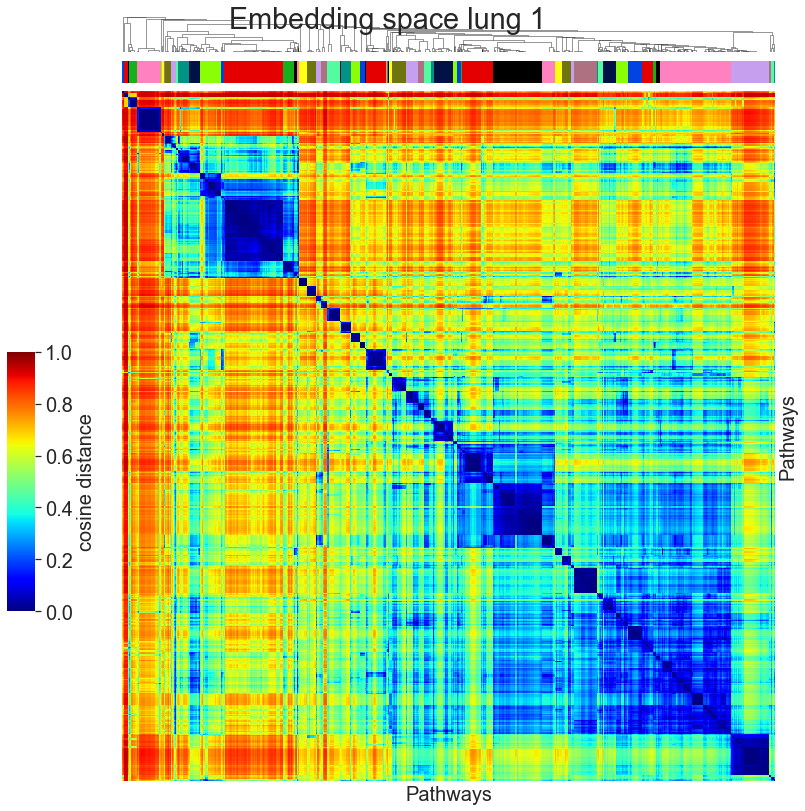

In [261]:
metric = 'cosine'
# for tissue, graphlet in product(TISSUES, GRAPHLETS):
for tissue, graphlet in product(['lung'], [1]):
    embedding_fp = f'./embeddings/embedding_PNMTF_PPI_healthy_{tissue}_{graphlet}.pickle' 
    embedding = load(embedding_fp)
    coordinates = embedding.get_pathway_2_coordinates()
    dist_matrix =  pdist(coordinates, metric=metric)  # Not in square form
    row_linkage = hierarchy.linkage(dist_matrix, method='average')
    col_linkage = hierarchy.linkage(dist_matrix.T, method='average')
    
    __plot_clustergrid(row_linkage, 
                       col_linkage, 
                       no_clusters=65, 
                       cbar_label=f'{metric} distance', 
                       title=f'Embedding space {tissue} {graphlet} ', 
                       file_path=None)
    

# Pathway-level analysis

## Thresholding

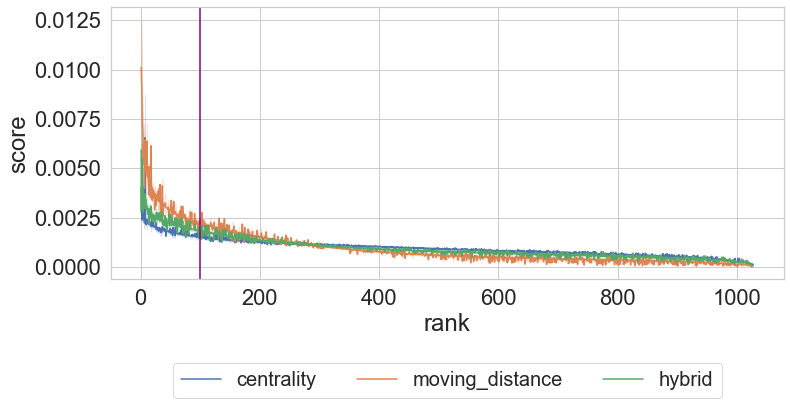

In [267]:
def plot_elbow_analysis_pathways():
    dfs = []
    for tissue, graphlet, score_method in product(TISSUES, GRAPHLETS, SCORE_METHODS):
        fp = f'./pathway_scores/pathway_scores_PNMTF_{score_method}_{tissue}_{graphlet}.csv'
        df = pd.read_csv(fp)
        df = df.dropna()
        df['rank'] = df.score.rank(ascending=False)
        df = df.sort_values(by=['score'], ascending=False)
        df['tissue'] = tissue
        dfs.append(df)
    df = pd.concat(dfs)    
    __plot_lineplot(df, x='rank', y='score', hue='score_method', vline= THRESHOLD_PATHWAYS)


plot_elbow_analysis_pathways()

## Prediction accuracy

### Correlation scores

In [45]:
def plot_cancer_scores_pathways_correlation_ratio_drivers():
    
    # Compute and store correlations
    records = []
    for tissue, graphlet, score_method in product(TISSUES, GRAPHLETS, SCORE_METHODS):
        pathway_2_driver_ratio = __read_pathway_2_driver_ratio(tissue)
        fp = f'./pathway_scores/pathway_scores_PNMTF_{score_method}_{tissue}_{graphlet}.csv'
        df = pd.read_csv(fp)
        df['driver_ratio']  = df.apply(lambda row: pathway_2_driver_ratio[row['entity']],axis=1)
        corr, pval = spearmanr(df['score'], df['driver_ratio'])
        graphlet_adj = '$\widetilde{A}_{G_%d}$'  % graphlet
        record = (tissue, graphlet, graphlet_adj, score_method, corr)
        records.append(record)
    
    # Transform correlation scores into pandas dataframe
    df_plot = pd.DataFrame.from_records(data=records, 
                                        columns = ['tissue', 
                                                   'graphlet', 
                                                   'graphlet_adj', 
                                                   'score_method', 
                                                   'Correlation'])

#     fp = f'figs/pathways_correlation_gas.pdf'
    fp = None
    __plot_barchart(df_plot,
                    x='graphlet_adj',y='Correlation', hue='score_method',
                    title='', ylim=(-0.1,0.51), ystep=0.1, file_path=fp)

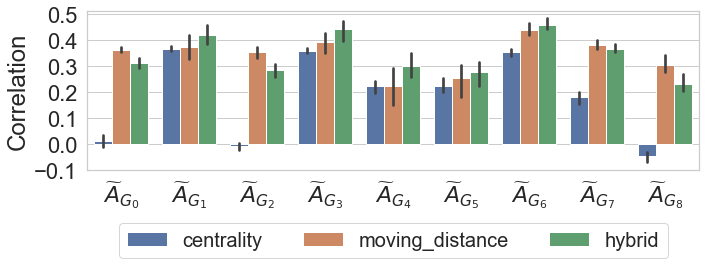

In [38]:
plot_cancer_scores_pathways_correlation_ratio_drivers()

### MCC scores

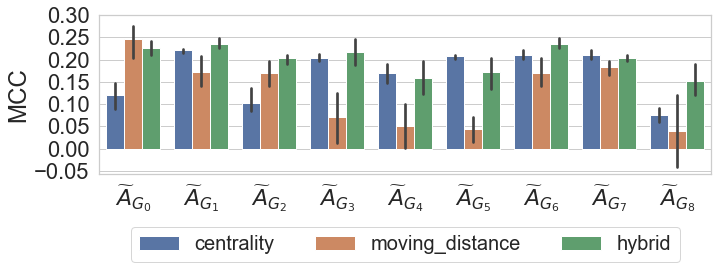

In [92]:
def plot_cancer_scores_pathways_mcc():
    cancer_pathways = __read_cancer_pathways()

    records = []
    for tissue, graphlet, score_method in product(TISSUES, GRAPHLETS, SCORE_METHODS):
#         df = __read_top_pathways(score_method, tissue, graphlet, THRESHOLD_PATHWAYS)
        
        fp = f'./pathway_scores/pathway_scores_PNMTF_{score_method}_{tissue}_{graphlet}.csv'
        df = pd.read_csv(fp)
        
        y_true = []
        y_pred = []
        for _, row in df.iterrows():
            y_pred.append(row['rank'] < THRESHOLD_PATHWAYS)
            y_true.append(row.entity in cancer_pathways)
            
        mcc = matthews_corrcoef(y_true, y_pred)
        
        graphlet_adj = '$\widetilde{A}_{G_%d}$'  % graphlet
        record = (tissue, graphlet, graphlet_adj, score_method, mcc)
        records.append(record)
        
    df_plot = pd.DataFrame.from_records(data=records, 
                                        columns = ['tissue', 
                                                   'graphlet', 
                                                   'graphlet_adj', 
                                                   'score_method', 
                                                   'MCC'])
#     fp = f'figs/pathways_mcc_gas.pdf'
    fp = None
    __plot_barchart(df_plot,
                    x='graphlet_adj',y='MCC', hue='score_method',
                    title='', ylim=(-0.05,0.31), ystep=0.05, file_path=fp)
    
plot_cancer_scores_pathways_mcc()

# Gene-level analysis

## Thresholding

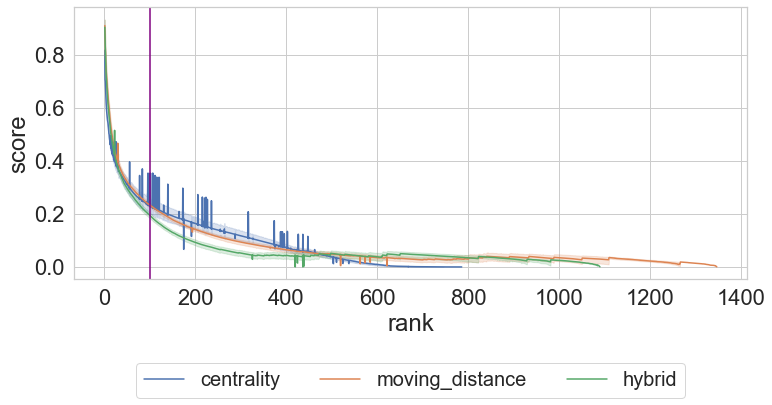

In [266]:
def plot_elbow_analysis_genes():
    dfs = []
    for tissue, graphlet, score_method in product(TISSUES, GRAPHLETS, SCORE_METHODS):
        df =__read_genes_for_top_pathways(score_method, tissue, graphlet)
        df['tissue'] = tissue
        dfs.append(df)
    df = pd.concat(dfs)    
    __plot_lineplot(df, x='rank', y='score', hue='score_method', vline= THRESHOLD_GENES)


plot_elbow_analysis_genes()

## Prediction accuracy

# MCC

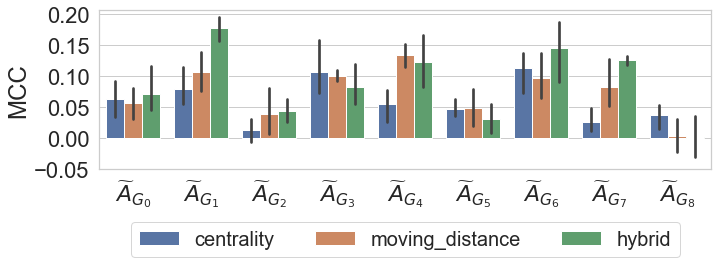

In [224]:
def plot_cancer_scores_genes_mcc():
    cancer_genes = __read_cancer_genes()
    records = []
    for tissue, graphlet, score_method in product(TISSUES, GRAPHLETS, SCORE_METHODS):

        df =  __read_genes_for_top_pathways(score_method, tissue, graphlet)
        y_true = []
        y_pred = []
        for _, row in df.iterrows():
            y_pred.append(row['rank'] < THRESHOLD_GENES)
            y_true.append(row.entity in cancer_genes)
            
        mcc = matthews_corrcoef(y_true, y_pred)
        
        graphlet_adj = '$\widetilde{A}_{G_%d}$'  % graphlet
        record = (tissue, graphlet, graphlet_adj, score_method, mcc)
        records.append(record)
        
    df_plot = pd.DataFrame.from_records(data=records, 
                                        columns = ['tissue', 
                                                   'graphlet', 
                                                   'graphlet_adj', 
                                                   'score_method', 
                                                   'MCC'])
#     fp = f'figs/genes_mcc_gas.pdf'
    fp = None
    __plot_barchart(df_plot,
                    x='graphlet_adj',y='MCC', hue='score_method',
                    title='', ylim=(-0.05, .25),ystep=0.05,file_path=fp)
    
plot_cancer_scores_genes_mcc()

In [264]:
def plot_top_genes_table_for_validation(score_method, tissue, graphlet, top_threshold):
    cancer_genes = __read_cancer_genes()
    ts_cancer_genes = __read_cancer_genes_tissue_specific(tissue)
    
    immune_pathways = __read_immune_pathways()
    cancer_pathways = __read_cancer_pathways()
    
    entrez_2_symbol = __read_entrez_2_symbol()
    path_2_name = __read_path_2_name()
    gene_2_drugs = __read_gene_2_drugs({'approved','investigational'})
    drug_2_name = __read_drug_2_name()
    gene_2_prognostic = __read_gene_2_prognostic(tissue)
    
               
    df =  __read_genes_for_top_pathways(score_method, tissue, graphlet)
    df = df[:top_threshold]       
        
    df['cancer_gene_generic'] =  df['entity'].isin(cancer_genes)
    df['cancer_gene_tissue_specific'] = df['entity'].isin(ts_cancer_genes)
    df['cancer pathway'] = df.apply(lambda row: row['pathway'] in cancer_pathways ,axis=1)
        
    df['Symbol'] = df.apply(lambda row: __map_entrez_to_symbol(row['entity'], 
                                                                   entrez_2_symbol), 
                                axis=1)
    
    df['prognostic'] = df.apply(lambda row: __map_gene_to_clinical_pval(row['entity'],
                                                                               gene_2_prognostic), 
                                       axis=1)
    df['path_name'] = df.apply(lambda row: path_2_name[row['pathway']],axis=1)
        
    df['drug'] = df.apply(lambda row: __map_symbol_2_drug(row['Symbol'], gene_2_drugs, drug_2_name), axis=1)
        
    df['immune_system'] = df.apply(lambda row: row['pathway'] in immune_pathways, axis=1)

    with pd.option_context("max_colwidth", 1000):    
        display(df[['Symbol', 
                    'cancer_gene_generic', 
                    'cancer_gene_tissue_specific', 
                    'prognostic', 
                    'path_name', 
                    'drug', 
                    'immune_system']])
        
    
for tissue in TISSUES:
    print(tissue)
    plot_top_genes_table_for_validation(score_method='hybrid', 
                                        tissue=tissue, 
                                        graphlet=1, 
                                        top_threshold=15)

lung


Symbol  cancer_gene_generic  cancer_gene_tissue_specific prognostic  \
2       PTPN11                 True                        False       None   
13712     GNB1                False                        False       None   
1303      GRB2                False                        False       None   
27520      MYC                 True                        False       None   
1139      CUL1                False                        False       None   
1300      EGFR                 True                        False       None   
28992     XPO1                 True                        False       None   
19528  HNRNPH1                False                        False       None   
13710     GNG2                False                        False       None   
8792     PTPRJ                False                        False       None   
14322    UBE2I                False                        False       None   
804     PIK3R1                 True                        False       None   
11993    HSPA8                False                        False       None   
13713     GNB2                False                        False       None   
14326    HDAC4                False                        False       None   

                                                                            path_name  \
2                                                             Interleukin-6 signaling   
13712                                       G beta:gamma signalling through PI3Kgamma   
1303                                                     Signaling by ERBB2 in Cancer   
27520  Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors   
1139                                                     Prolactin receptor signaling   
1300                                                     Signaling by ERBB2 in Cancer   
28992                                                Extra-nuclear estrogen signaling   
19528                                                              Signaling by FGFR2   
13710                                       G beta:gamma signalling through PI3Kgamma   
8792                                       Phosphorylation of CD3 and TCR zeta chains   
14322                                          SUMOylation of intracellular receptors   
804                                                  GPVI-mediated activation cascade   
11993                                                               Attenuation phase   
13713                                       G beta:gamma signalling through PI3Kgamma   
14326                                          SUMOylation of intracellular receptors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                drug  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

colon


Symbol  cancer_gene_generic  cancer_gene_tissue_specific  prognostic  \
2      PTPN11                 True                        False         NaN   
19652   TRAF2                False                        False    0.000932   
1107     LMNA                 True                        False         NaN   
28353    XPO1                 True                        False         NaN   
1064     CUL1                False                        False         NaN   
8668    PTPRJ                False                        False         NaN   
1228     GRB2                False                        False         NaN   
19647   BIRC3                 True                        False    0.000935   
13487    GNB1                False                        False         NaN   
1225     EGFR                 True                        False         NaN   
736    PIK3R1                 True                         True         NaN   
13486    GNG2                False                        False         NaN   
8675     PAK1                False                        False    0.000588   
11807   HSPA8                False                        False    0.000006   
13488    GNB2                False                        False         NaN   

                                                                            path_name  \
2                                                             Interleukin-6 signaling   
19652  TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway   
1107                                                                 Meiotic synapsis   
28353                                                Extra-nuclear estrogen signaling   
1064                                                     Prolactin receptor signaling   
8668                                       Phosphorylation of CD3 and TCR zeta chains   
1228                                                     Signaling by ERBB2 in Cancer   
19647  TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway   
13487                                       G beta:gamma signalling through PI3Kgamma   
1225                                                     Signaling by ERBB2 in Cancer   
736                                                  GPVI-mediated activation cascade   
13486                                       G beta:gamma signalling through PI3Kgamma   
8675                                         Generation of second messenger molecules   
11807                                                               Attenuation phase   
13488                                       G beta:gamma signalling through PI3Kgamma   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                drug  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

ovary


Symbol  cancer_gene_generic  cancer_gene_tissue_specific  prognostic  \
20443   TRIM25                False                        False         NaN   
2       PTPN11                 True                        False         NaN   
31065     LMNA                 True                        False         NaN   
28949     XPO1                 True                        False         NaN   
5441     YWHAB                False                        False         NaN   
14278    UBE2I                False                        False         NaN   
27411      MYC                 True                        False    0.000752   
7569   HNRNPH1                False                        False         NaN   
12209      FN1                False                        False         NaN   
18920     PRC1                False                        False         NaN   
6557     AP2M1                False                        False         NaN   
1257      EGFR                 True                        False         NaN   
1263      GRB2                False                        False         NaN   
6556      CLTC                 True                        False         NaN   
780     PIK3R1                 True                        False         NaN   

                                                                            path_name  \
20443                                                  Ovarian tumor domain proteases   
2                                                             Interleukin-6 signaling   
31065                                               Diseases of programmed cell death   
28949                                                Extra-nuclear estrogen signaling   
5441                                                  Prolonged ERK activation events   
14278                                          SUMOylation of intracellular receptors   
27411  Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors   
7569                                                                Signaling by FGFR   
12209                                 p130Cas linkage to MAPK signaling for integrins   
18920                                                        RHO GTPases activate CIT   
6557                                               Retrograde neurotrophin signalling   
1257                                                               Signaling by ERBB2   
1263                                                               Signaling by ERBB2   
6556                                               Retrograde neurotrophin signalling   
780                                                  GPVI-mediated activation cascade   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                drug  \
20443                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

prostate


Symbol  cancer_gene_generic  cancer_gene_tissue_specific prognostic  \
1193     LMNA                 True                        False       None   
4090    NTRK1                 True                        False       None   
20431   HMGB1                False                        False       None   
19060    PRC1                False                        False       None   
20429    TLR4                False                        False       None   
1314     GRB2                False                        False       None   
27695     MYC                 True                        False       None   
824    PIK3R1                 True                        False       None   
1311     EGFR                 True                        False       None   
29154    XPO1                 True                        False       None   
13872    GNB1                False                        False       None   
13870    GNG2                False                        False       None   
20430    TLR2                False                        False       None   
20432    TLR6                False                        False       None   
16788   BIRC3                 True                        False       None   

                                                                            path_name  \
1193                                                                 Meiotic synapsis   
4090                                                                Signalling to RAS   
20431                                          Regulation of TLR by endogenous ligand   
19060                                                        RHO GTPases activate CIT   
20429                                          Regulation of TLR by endogenous ligand   
1314                                                     Signaling by ERBB2 in Cancer   
27695  Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors   
824                                                  GPVI-mediated activation cascade   
1311                                                     Signaling by ERBB2 in Cancer   
29154                                                Extra-nuclear estrogen signaling   
13872                                       G beta:gamma signalling through PI3Kgamma   
13870                                       G beta:gamma signalling through PI3Kgamma   
20430                                          Regulation of TLR by endogenous ligand   
20432                                          Regulation of TLR by endogenous ligand   
16788                                               RIPK1-mediated regulated necrosis   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                drug  \
1193                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         